*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module05_02_cross_validation.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
np.set_printoptions(precision=4)
import matplotlib.pyplot as plt

# Evaluating classifiers:  cross validation 

### Is more data better?


Perhaps our primary goal when training machine learning classifiers is generalization. We will find that generalization comes with a great deal of nuance - but let us start with some basics hinging upon the following question:

> Does having more training examples improve performance on unseen (test) data? 

Intuitively, that answer would appear to be an obvious 'yes'; the more data we have available, the more accurate our classifiers should become.  To demonstrate this, let's evaluate a k-nearest neighbor classifier on a fixed test set with increasing number of training examples.  The resulting curve of accuracy as a function of number of examples is called a **learning curve**.

Our first step is to create a fixed test set to evaluate the classifier:

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = load_digits(return_X_y=True)

training_sizes = [20, 40, 100, 200, 400, 600, 800, 1000]

# note the use of the stratify keyword: it makes it so that each 
# class is equally represented in both train and test set
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size = len(y)-max(training_sizes), 
    stratify=y, random_state=1)

print(f'We have selected {X_test.shape[0]} test images from {X.shape[0]} images total.')
print(f'The remaining {X_full_train.shape[0]} images are available for training.')


We have selected 797 test images from 1797 images total.
The remaining 1000 images are available for training.


In the next part we will generate different sized training sets from our available training data and evaluate the classifier trained on each training set:

In [3]:
accuracy = []
for training_size in training_sizes :
    X_train,_ , y_train,_ = train_test_split(
        X_full_train, y_full_train, test_size = 
        len(y_full_train)-training_size+10, stratify=y_full_train)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(np.sum((y_pred==y_test))/len(y_test))
    print(f'training size: {X_train.shape[0]} \t accuracy: {accuracy[-1]:5.3f}')

training size: 10 	 accuracy: 0.581
training size: 30 	 accuracy: 0.853
training size: 90 	 accuracy: 0.927
training size: 190 	 accuracy: 0.955
training size: 390 	 accuracy: 0.980
training size: 590 	 accuracy: 0.980
training size: 790 	 accuracy: 0.981
training size: 990 	 accuracy: 0.987


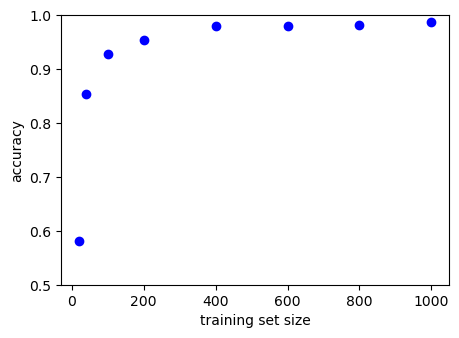

In [4]:
plt.figure(figsize=(5,3.5))
plt.plot(training_sizes, accuracy, 'ob')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.ylim((0.5,1));

### Reflection

* What can you conclude from this plot?  
* Why would you want to compute a learning curve on your data?


### Making better use of our data with cross validation

The discussion above demonstrates that it is best to have as large of a training set as possible.  We also need to have a large enough test set, so that the accuracy estimates are accurate.  How do we balance these two contradictory requirements?  Cross-validation provides us a more effective way of using our data that enables maximizing the size of both the training and test sets at the same time.  Here is the pseudo-code:

**$k$-fold cross validation**

* Randomly partition the data into $k$ subsets ("folds").
* Set one fold aside for evaluation and train a model on the remaining $k-1$ folds and evaluate it on the held-out fold.
* Repeat until each fold has been used for evaluation
* Compute accuracy by averaging over the accuracy estimates generated for each fold.

Here is an illustration of 8-fold cross validation:


<img style="padding: 10px; float:center;" alt="cross-validation by MBanuelos22 CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif" width="600">


This procedure is clearly more expensive than dividing your data into training and test sets.  However, when dealing with relatively small datasets, which is when you want to use this procedure, this won't be an issue.

Typically cross-validation is used with the number of folds being in the range of 5-10.  An extreme case is when the number of folds equals the number of training examples.  This special case is called *leave-one-out cross-validation*.

Let's use the scikit-learn breast cancer dataset to demonstrate the use of cross-validation.

In [5]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
print('number of examples ', len(y))
print('number of features ', len(X[0]))
print('labels: ', data.target_names)

number of examples  569
number of features  30
labels:  ['malignant' 'benign']


In [6]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state=0)
classifier = KNeighborsClassifier(n_neighbors=3)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

But first, we'll compute accuracy using our train and test sets:

In [7]:
np.mean(y_pred==y_test)

0.9385964912280702

Now let's compute accuracy using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) instead:

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics

np.set_printoptions(precision=3)
accuracy = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
print(accuracy)

[0.877 0.921 0.947 0.939 0.912]


This yields an array containing the accuracy values for each fold.
When reporting your results, you will typically show the mean:

In [9]:
np.mean(accuracy)

0.9191429902189101

The arguments of `cross_val_score`:
* A classifier (anything that satisfies the scikit-learn classifier API)
* data (feature matrix and labels)
* `cv` : an integer that specifies the number of folds (can be used in more sophisticated ways as we will see below).
* `scoring`: this determines which accuracy measure is evaluated for each fold.  Here's a link to the  [list of available measures](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) in scikit-learn.

You can obtain accuracy for other metrics.  *Balanced accuracy* for example, is appropriate when the data is unbalanced (e.g. when one class contains a much larger number of examples than other classes in the data).

In [10]:
accuracy = cross_val_score(classifier, X, y, cv=5, 
                           scoring='balanced_accuracy')
np.mean(accuracy)

0.9080478348124925

`cross_val_score` is somewhat limited, in that it simply returns a list of accuracy scores.  In practice, we often want to have more information about what happened during training, and also to compute multiple accuracy measures.
[cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) will provide you with that information:

In [11]:
results = cross_validate(classifier, X, y, cv=5, 
                         scoring='accuracy', return_estimator=True)
print(results)

{'fit_time': array([0.   , 0.001, 0.   , 0.   , 0.   ]), 'score_time': array([0.003, 0.003, 0.002, 0.003, 0.002]), 'estimator': [KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=3)], 'test_score': array([0.877, 0.921, 0.947, 0.939, 0.912])}


The object returned by `cross_validate` is a Python dictionary as the output suggests.  To extract a specific piece of data from this object, simply access the dictionary with the appropriate key:

In [12]:
results['test_score']

array([0.877, 0.921, 0.947, 0.939, 0.912])

If you would like to know the predictions made for each training example during cross-validation use [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) instead:

In [13]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(classifier, X, y, cv=5)

np.mean(y==y_pred)

0.9191564147627417

As you would expect, there is a prediction for each example in the dataset:

In [14]:
len(y_pred)

569

### Want more control?

The above way of performing cross-validation doesn't always give us enough control over the process:  we usually want our machine learning experiments be reproducible, and to be able to use the same cross-validation splits with multiple algorithms.  The scikit-learn `KFold` and `StratifiedKFold` cross-validation generators are the way to achieve that.  

`KFold` is a Python generator object that chooses a random subset of examples for each fold.  This strategy can lead to cross-validation folds in which the classes are not well-represented as the following toy example demonstrates:

In [15]:
from sklearn.model_selection import StratifiedKFold, KFold

X_toy = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9,10], [11, 12]])
y_toy = np.array([0, 0, 1, 1, 1, 1])
cv = KFold(n_splits=2, random_state=42, shuffle=True)
#cv = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
i  = 1
for train_idx, test_idx in cv.split(X_toy, y_toy):
    print(f'Split {i}')
    print(f'\t Test: {test_idx} Train: {train_idx}')
    X_train, X_test = X_toy[train_idx], X_toy[test_idx]
    y_train, y_test = y_toy[train_idx], y_toy[test_idx]
    print(f'\t Training labels are: {y_train}')
    i = i + 1

Split 1
	 Test: [0 1 5] Train: [2 3 4]
	 Training labels are: [1 1 1]
Split 2
	 Test: [2 3 4] Train: [0 1 5]
	 Training labels are: [0 0 1]


### Stratified sampling using `StratifiedKFold`

`StratifiedKFold` addresses this issue by making sure that each class is represented in each fold in proportion to its overall fraction in the data.  This is particularly important when one or more of the classes have few examples.

`StratifiedKFold` and `KFold` generate folds that can be used in conjunction with the cross-validation methods we saw above.
As an example, we will demonstrate the use of `StratifiedKFold` with `cross_val_score` on the breast cancer datast:

In [16]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
accuracy = cross_val_score(classifier, X, y, cv=cv, 
                           scoring='accuracy')
np.mean(accuracy)

0.935010091600683

For classification problems, `StratifiedKFold` is the preferred strategy.  However, for regression problems `KFold` is the way to go.

#### Why KFold for regression?

* Why do we use `KFold` rather than `StratifiedKFold` for performing cross-validation for regression problems?

### Visualizing cross-validation

To clarify the distinction between the different methods of generating cross-validation folds and their different parameters let's look at the following figures:

In [17]:
# the code originated with the example in ...
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
from matplotlib.colors import ListedColormap

np.random.seed(42)
n_folds = 4

# Generate the data
X = np.random.randn(100, 10)

# generate labels - classes 0,1,2 and 10,30,60 examples, respectively
y = np.array([0] * 10 + [1] * 30 + [2] * 60)

def plot_cv_indices(cv, X, y, ax, n_folds):
    """plot the indices of a cross-validation object."""
    line_width = 25
    mark_size = 25
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.zeros(len(X))
        indices[tt] = 1
        # Visualize the results
        fold_cmap = ListedColormap(['darkgreen','orangered'])
        ax.scatter(range(len(indices)), [ii] * len(indices),
                   c=indices, marker="_", lw=line_width, s=mark_size, 
                   cmap=fold_cmap)
   
    # Plot the data classes and groups at the end
    labs_cmap = ListedColormap(['plum','purple','fuchsia'])
    ax.scatter(range(len(X)), [ii+1] * len(X), c=y, marker='_', 
               s=mark_size, lw=line_width,
               cmap=labs_cmap)

   # Formatting
    ax.set(ylim=[5,-1])
    yticklabels = list(range(1,n_folds+1)) + ['class']
    ax.set(yticks=np.arange(n_folds + 1), yticklabels=yticklabels)
    ax.set(xlabel='index', ylabel="CV fold")
    ax.set_title('{}'.format(type(cv).__name__), fontsize=16)
    return ax

Let's visualize the results of using `KFold` for fold generation:

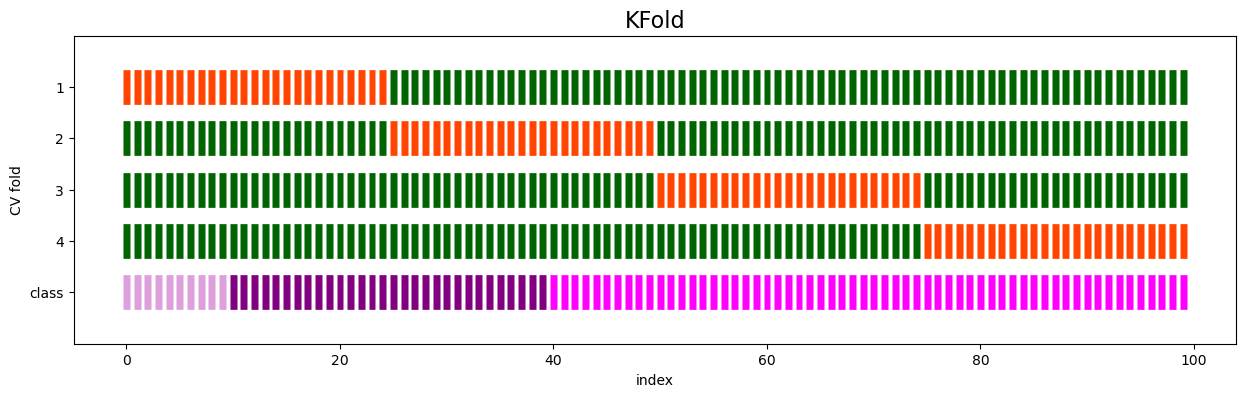

In [18]:
fig, ax = plt.subplots(figsize=(15,4))
cv = KFold(n_folds)
plot_cv_indices(cv, X, y, ax, n_folds);

As you can see, this naive way of using `KFold` can lead to highly undesirable splits into cross-validation folds.
Using `StratifiedKFold` addresses this to some extent:

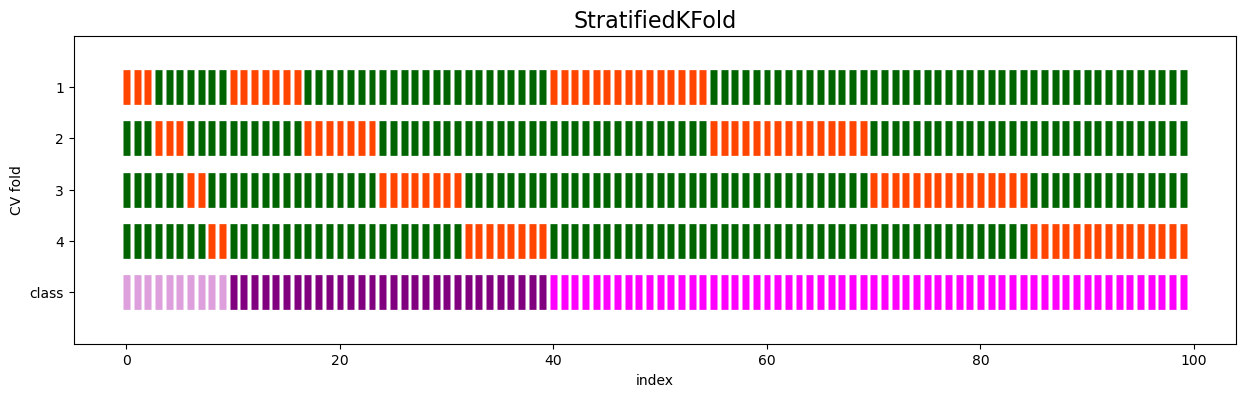

In [19]:
fig, ax = plt.subplots(figsize=(15,4))
cv = StratifiedKFold(n_folds)
plot_cv_indices(cv, X, y, ax, n_folds);

Using `StratifiedKFold` with shuffling of the examples is the preferred way of splitting the data into folds:

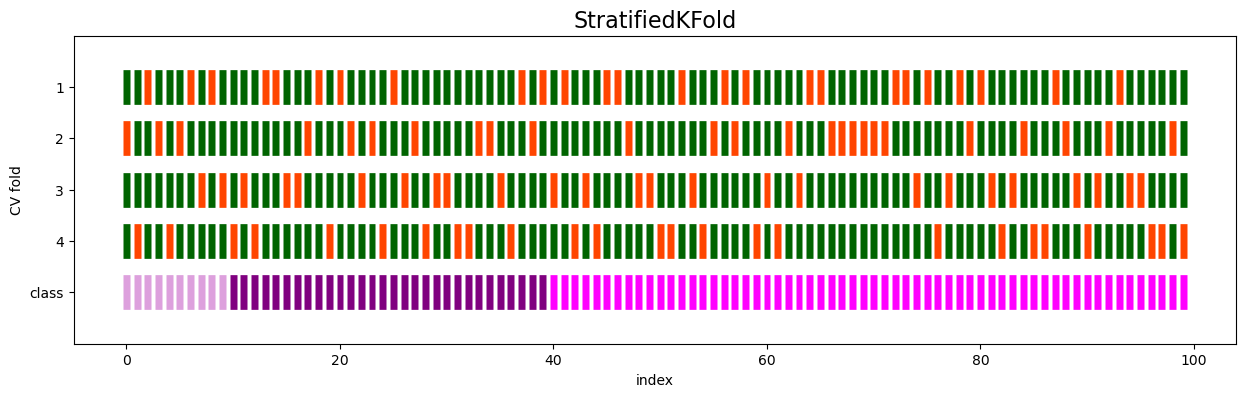

In [20]:
fig, ax = plt.subplots(figsize=(15,4))
cv = StratifiedKFold(n_folds, shuffle=True)
plot_cv_indices(cv, X, y, ax, n_folds);

#### Why shuffle?

Reflect on why it is important to shuffle the data when using `KFold` or `StratifiedKFold`.

#### Different ways of applying cross-validation

The way you apply cross-validation sometimes depends on the nature of the problem you are trying to address.
Consider for example the task of digitizing handwritten text (aka optical character recognition, or OCR).  For each letter in the alphabet you have multiple labeled examples generated by the same writer.  How would this setup affect the way you divide your examples into training and test sets, or when performing cross-validation?


### Leave One Out cross-validation

A limiting case for k-fold cross validation is to have as many folds as there are are examples.  This results in what is called **leave-one-out cross-validation**. To be clear, how this works that given $N$  examples one builds $N$ models trained on a set from which **only one** example is removed from training and used for testing. 

The only situation you would use leave-one-out cross-validation is where you have an extremely small dataset.
In some domains of interest, especially in medical data where it is often impossible to collect large number samples.

### Summary and Discussion

In this notebook we discussed cross-validation as a more effective way to make use of limited amounts of data compared to the strategy of splitting data into train and test sets.  For very large datasets where training is  time consuming you might still opt for evaluation on a single test set.
